In [1]:
import pandas as pd
import json
import os
from snowflake.connector import connect

# Read the config.json file
with open('config.json', 'r') as file:
    config = json.load(file)

# Connection setup
conn = connect(
  user=config['user'],
  password=config['password'],
  account= config['account'],
)

# 1. Fetch Data from Snowflake

In [2]:
conn.cursor().execute(f"USE WAREHOUSE {config['warehouse']}")
conn.cursor().execute(f"USE DATABASE {config['database']}")
conn.cursor().execute(f"USE SCHEMA {config['schema']}")

In [3]:
# Define the SQL query to fetch the data from the table
query = "SELECT * FROM " + config['testtable']

# Execute the query and load the result into a DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Print the first 5 rows
print(df.head())


   PID  MANUFACTURER     group CONTENT UNIT PHARMFORM  GENERICPRODUCT  \
0    1             1      2FOI      80   ST       TAB               0   
1    2             1      2FOI      80   ST       Tab               0   
2    3             1      2FOI      10    G       GLO               0   
3    4             1      2FOI      80   ST       TAB               0   
4    5             2  10OJ03JS       8   ST       PUL               0   

   SALESINDEX  CATEGORY CAMPAIGNINDEX    RRP  
0          40       NaN          None  10.89  
1          40       NaN          None  10.89  
2          40       NaN          None  16.45  
3          40       NaN          None  10.89  
4          40       1.0          None  22.53  


# 2. Perform Analyses

### 2.1 Descriptive Statistics

In [4]:
summary = df.describe()
print(summary)

                PID  MANUFACTURER  GENERICPRODUCT    SALESINDEX      CATEGORY  \
count  22035.000000  22035.000000    22035.000000  22035.000000  17408.000000   
mean   11018.000000    222.488042        0.033674     48.367461    113.933996   
std     6361.100927    223.103100        0.180392      6.166422     93.823387   
min        1.000000      1.000000        0.000000     40.000000      1.000000   
25%     5509.500000     60.000000        0.000000     40.000000     35.000000   
50%    11018.000000    156.000000        0.000000     53.000000     90.000000   
75%    16526.500000    311.000000        0.000000     53.000000    169.000000   
max    22035.000000   1067.000000        1.000000     53.000000    409.000000   

                RRP  
count  22035.000000  
mean      17.861648  
std       19.823213  
min        0.070000  
25%        7.260000  
50%       12.080000  
75%       21.270000  
max      404.970000  


The descriptive statistics provide a summary of the numerical columns in the dataset:

- pid: Ranges from 1 to 22035, representing product IDs.
- manufacturer: Manufacturer IDs, ranging from 1 to 1067.
- genericProduct: Binary indicator for generic products, with values of 0 or 1.
- salesIndex: Sales index ranging from 40 to 53.
- category: Category ID, ranging from 1 to 409 (some missing values).
- rrp: Recommended retail price, ranging from 0.07 to 404.97.

### 2.2 Correlation Analysis

In [5]:
correlation_matrix = df.corr()
print(correlation_matrix)

                     PID  MANUFACTURER  GENERICPRODUCT  SALESINDEX  CATEGORY  \
PID             1.000000      0.202037       -0.048586    0.183852  0.085262   
MANUFACTURER    0.202037      1.000000       -0.025484    0.211010  0.065263   
GENERICPRODUCT -0.048586     -0.025484        1.000000   -0.253311 -0.066375   
SALESINDEX      0.183852      0.211010       -0.253311    1.000000 -0.045341   
CATEGORY        0.085262      0.065263       -0.066375   -0.045341  1.000000   
RRP             0.036015      0.058095       -0.020167   -0.010174  0.002696   

                     RRP  
PID             0.036015  
MANUFACTURER    0.058095  
GENERICPRODUCT -0.020167  
SALESINDEX     -0.010174  
CATEGORY        0.002696  
RRP             1.000000  


The correlation matrix shows the linear relationship between the numerical variables in the dataset:

- pid and manufacturer: Positive correlation (0.202), indicating that higher product IDs tend to have higher manufacturer IDs.
- genericProduct and salesIndex: Negative correlation (-0.253), implying that generic products tend to have lower sales indices.
- Other correlations are relatively weak.

### 2.3 Clustering and Segmentation

- Segmenting the products into 3 clusters based on the manufacturer, salesIndex, and rrp columns.

In [13]:
from sklearn.cluster import KMeans

# Assuming you want to cluster into 3 groups
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(df[['MANUFACTURER', 'SALESINDEX', 'RRP']])
df[['MANUFACTURER', 'SALESINDEX', 'RRP']].head()

,MANUFACTURER,SALESINDEX,RRP
0,1,40,10.89
1,1,40,10.89
2,1,40,16.45
3,1,40,10.89
4,2,40,22.53


The clustering has segmented the products into three clusters based on the manufacturer, salesIndex, and rrp columns. 

### 2.4 Visualization

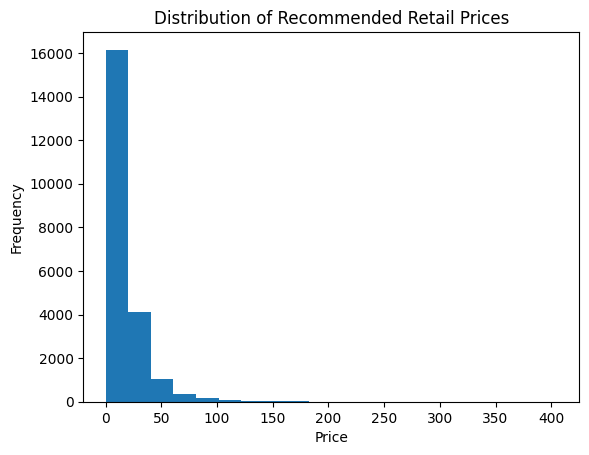

In [15]:
import matplotlib.pyplot as plt

# Histogram for the Recommended Retail Price (rrp)
plt.hist(df['RRP'], bins=20)
plt.title('Distribution of Recommended Retail Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

- The histogram visualizes the distribution of the Recommended Retail Prices (rrp) in the dataset. From the graph, we can see that most of the products have prices in the lower range, with a few products having higher prices.

# 3. Potential predictive modeling scenario (example)

### 3.1 Predicting Recommended Retail Price (RRP)
- Target Variable: rrp (Recommended Retail Price)
- Features: Other variables like manufacturer, group, content, unit, pharmForm, genericProduct, salesIndex, category

* Model Options:
- Linear Regression: Suitable for predicting a continuous outcome.
- Random Forest Regressor: A more complex model that can capture non-linear relationships.


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Selecting Features and Target
X = df[['MANUFACTURER', 'GENERICPRODUCT', 'SALESINDEX', 'CATEGORY']].fillna(0) # Example features
y = df['RRP']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions on the test set
predictions = model.predict(X_test)

# Evaluating the model using R^2 score and Mean Absolute Error
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

r2, mae


(0.0022361873400572607, 11.73935710320384)

#### R² Score: 
- 0.0022 (Approximately)
#### Mean Absolute Error (MAE): 
- 11.74
### Interpretation:
- R² Score: The R² score indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. A value close to 1 indicates a good fit, while a value close to 0 indicates a poor fit. In this case, the R² score is very close to 0, suggesting that the model does not explain much of the variability in the RRP.
- Mean Absolute Error: The MAE measures the average absolute error between the true values and the predicted values. A lower MAE is generally better. In this case, the MAE is 11.74, which means that, on average, the predictions are off by this amount.

### Possible Improvements:
The current model's performance is not satisfactory, and there might be several reasons for this. Here are some potential improvements:

- Feature Engineering: Creating new features or transforming existing ones to capture more information.
- Handling Categorical Variables: Encoding categorical variables appropriately (e.g., one-hot encoding for nominal categories).
- Model Selection: Trying different algorithms that might be more suitable for this data.
- Hyperparameter Tuning: Tuning the model's hyperparameters to optimize performance.
These improvements require a more in-depth understanding of the data and the specific business problem, as well as iterative experimentation with different techniques.